## Initial testing on Oracle instance at NCSA

Continuation of the `DM-14712 Oracle initial test` notebook which grew too large

In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

import plots

# plots to draw in do_plots_all()
all_plots = ['select_real', 'store_real',
             'obj_select_real', 'obj_last_insert_real',
             'obj_insert_real', 'obj_store',
             'src_select_real', 'src_insert_real',
             'fsrc_select_real', 'fsrc_insert_real']

## 15x15 tiles, with optimizer hint

* Using LSST_ALERTS_SSD tablespace.
* Suspicion is that optimizer fails to find best plan for querying DiaObjectLast table until it collects enough statistics which takes long time (~1000 visits)
* Trying to remedy situation by adding optimizer hint for SELET on that query: `SELECT /*+ index("X15_DiaObjectLast" "X15_PK_DiaObjectLast") */ "X15_DiaObjectLast"."diaObjectId" ...`
* No noticeable improvement unfortunately

Timings from `dm-14712-oracle-ssd-15x15-20180712T172555.log.gz` and `dm-14712-oracle-ssd-15x15-20180716T113206.log.gz`:
```
2018-07-12 17:26:07,231 [INFO] lsst.l1dbproto.l1db: L1DB Configuration:
2018-07-12 17:26:07,231 [INFO] lsst.l1dbproto.l1db:     dia_object_index: last_object_table
2018-07-12 17:26:07,232 [INFO] lsst.l1dbproto.l1db:     dia_object_nightly: False
2018-07-12 17:26:07,233 [INFO] lsst.l1dbproto.l1db:     read_sources_months: 12
2018-07-12 17:26:07,233 [INFO] lsst.l1dbproto.l1db:     read_forced_sources_months: 6
2018-07-12 17:26:07,233 [INFO] lsst.l1dbproto.l1db:     dia_object_columns: ['diaObjectId', 'lastNonForcedSource', 'ra', 'decl', 'raSigma', 'declSigma', 'ra_decl_Cov', 'pixelId']
2018-07-12 17:26:07,234 [INFO] lsst.l1dbproto.l1db:     object_last_replace: True
2018-07-12 17:26:07,234 [INFO] lsst.l1dbproto.l1db:     schema_file: /project/salnikov/l1dbproto/data/l1db-schema.yaml
2018-07-12 17:26:07,234 [INFO] lsst.l1dbproto.l1db:     extra_schema_file: data/l1db-schema-extra-oracle.yaml
2018-07-12 17:26:07,234 [INFO] lsst.l1dbproto.l1db:     column_map: /project/salnikov/l1dbproto/data/l1db-afw-map.yaml
2018-07-12 17:26:07,234 [INFO] lsst.l1dbproto.l1db:     schema prefix: X15_
2018-07-12 17:26:09,049 [INFO] ap_proto: Will divide FOV into 15x15 regions
2018-07-12 17:26:09,050 [INFO] ap_proto: Start loading variable sources from 'var_sources.npy'
2018-07-12 17:26:10,047 [INFO] ap_proto: Finished loading variable sources, count = 21438735
2018-07-12 17:26:10,047 [INFO] ap_proto: lastSourceId: 0
2018-07-12 17:26:10,048 [INFO] ap_proto: +++ Start processing visit 1 at 2020-01-01 03:00:00
...
2018-07-13 08:56:16,705 [INFO] ap_proto: --- Finished processing visit 4377, time: real=7.076 user=1.161 sys=5.384

2018-07-16 11:32:22,665 [INFO] ap_proto: +++ Start processing visit 4378 at 2020-01-06 21:42:45
...
2018-07-16 12:28:00,494 [INFO] ap_proto: --- Finished processing visit 4877, time: real=6.772 user=1.211 sys=5.230
```

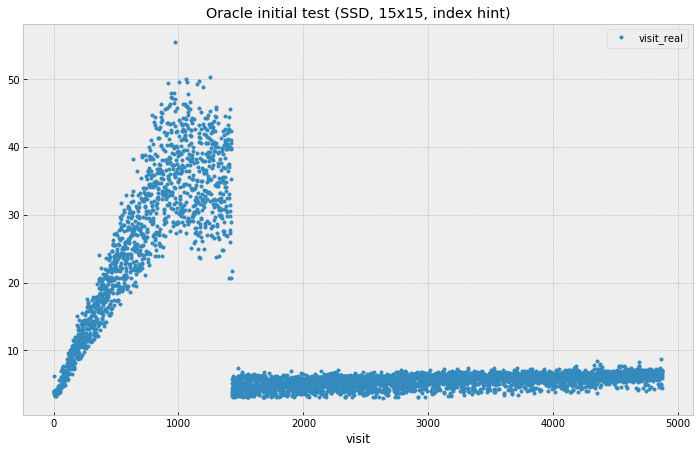

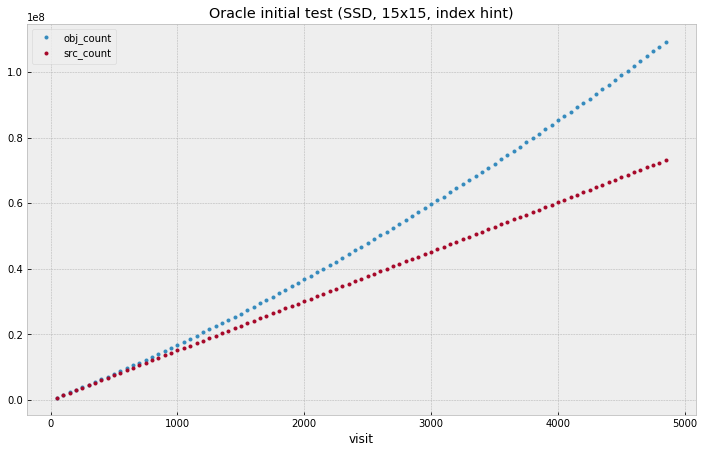

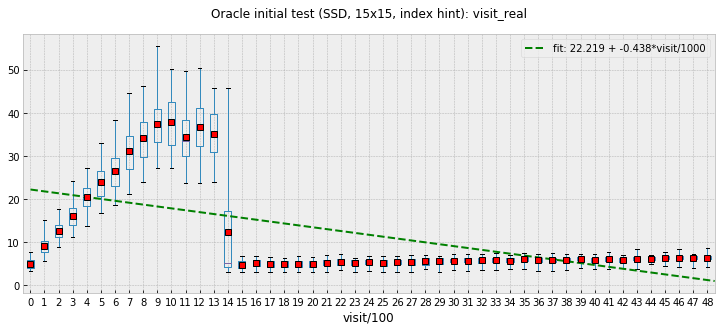

In [2]:
csv = "data/dm-14712-oracle-ssd-15x15-20180712T172555.csv.gz"
title = "Oracle initial test (SSD, 15x15, index hint)"
ds = plots.do_plots(csv, title, bin=100, filter_count=True)
# ds = plots.do_plots_all(csv, title, bin=100, filter_count=True, plots=all_plots)

## 15x15 tiles, pre-filled statistics

* Chris has dumped statistics from Oracle and suggested pre-loading it after re-creating tables
* Queries on DiaObjectLast also used index hint 
* There is a big improvement in that problematic region

Timings from `dm-14712-oracle-ssd-15x15-20180718T135354.log.gz`:
```
2018-07-18 13:54:10,963 [INFO] lsst.l1dbproto.l1db: L1DB Configuration:
2018-07-18 13:54:10,963 [INFO] lsst.l1dbproto.l1db:     dia_object_index: last_object_table
2018-07-18 13:54:10,964 [INFO] lsst.l1dbproto.l1db:     dia_object_nightly: False
2018-07-18 13:54:10,965 [INFO] lsst.l1dbproto.l1db:     read_sources_months: 12
2018-07-18 13:54:10,965 [INFO] lsst.l1dbproto.l1db:     read_forced_sources_months: 6
2018-07-18 13:54:10,966 [INFO] lsst.l1dbproto.l1db:     dia_object_columns: ['diaObjectId', 'lastNonForcedSource', 'ra', 'decl', 'raSigma', 'declSigma', 'ra_decl_Cov', 'pixelId']
2018-07-18 13:54:10,966 [INFO] lsst.l1dbproto.l1db:     object_last_replace: True
2018-07-18 13:54:10,966 [INFO] lsst.l1dbproto.l1db:     schema_file: /project/salnikov/l1dbproto/data/l1db-schema.yaml
2018-07-18 13:54:10,966 [INFO] lsst.l1dbproto.l1db:     extra_schema_file: data/l1db-schema-extra-oracle.yaml
2018-07-18 13:54:10,966 [INFO] lsst.l1dbproto.l1db:     column_map: /project/salnikov/l1dbproto/data/l1db-afw-map.yaml
2018-07-18 13:54:10,967 [INFO] lsst.l1dbproto.l1db:     schema prefix: X15_
2018-07-18 13:54:13,211 [INFO] ap_proto: Will divide FOV into 15x15 regions
2018-07-18 13:54:13,211 [INFO] ap_proto: Start loading variable sources from 'var_sources.npy'
2018-07-18 13:54:14,044 [INFO] ap_proto: Finished loading variable sources, count = 21438735
2018-07-18 13:54:14,044 [INFO] ap_proto: lastSourceId: 0
2018-07-18 13:54:14,044 [INFO] ap_proto: +++ Start processing visit 1 at 2020-01-01 03:00:00
...
2018-07-18 21:06:10,546 [INFO] ap_proto: --- Finished processing visit 5000, time: real=23.866 user=1.263 sys=4.886
```


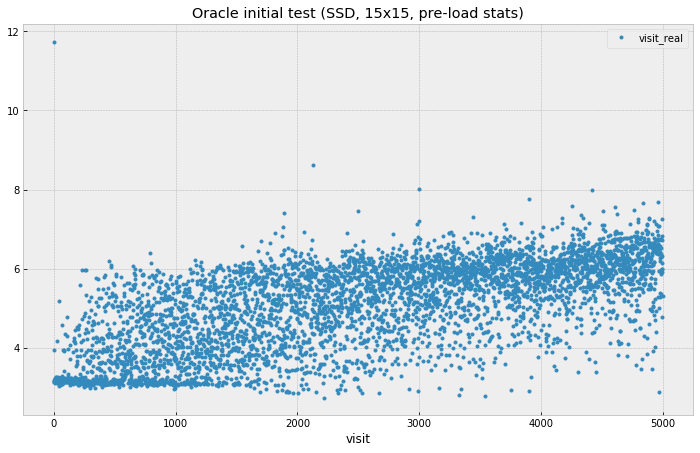

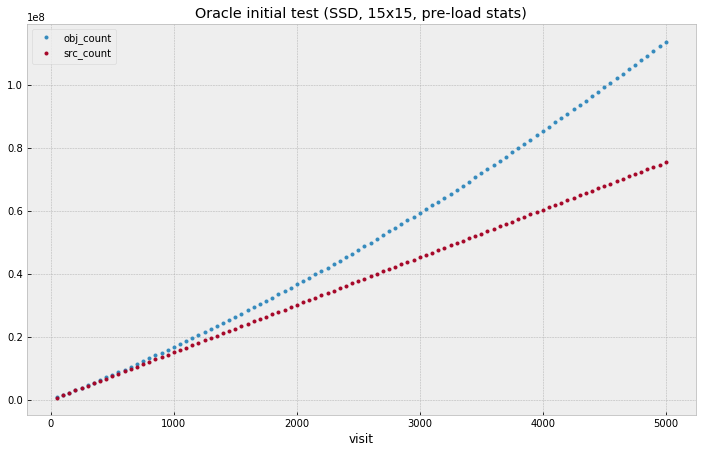

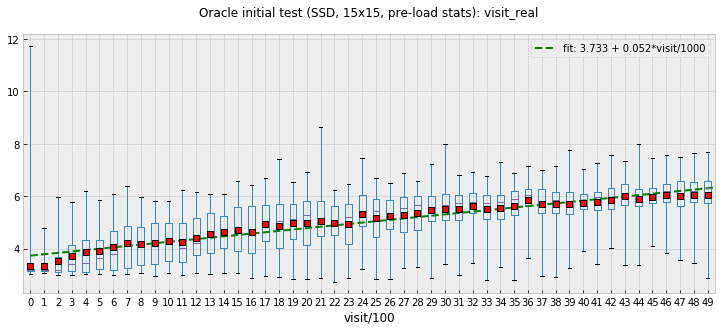

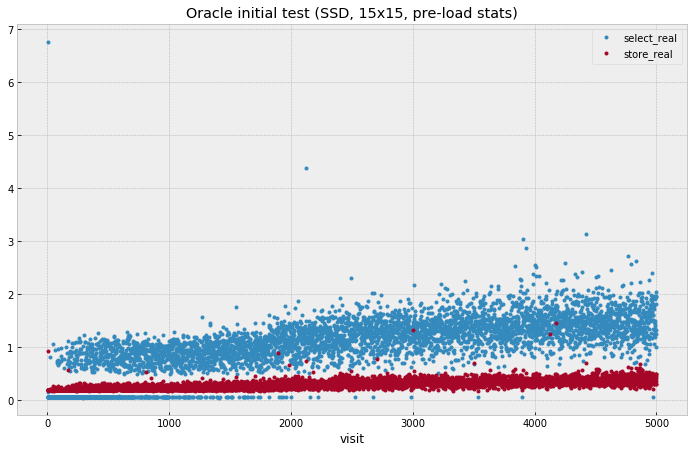

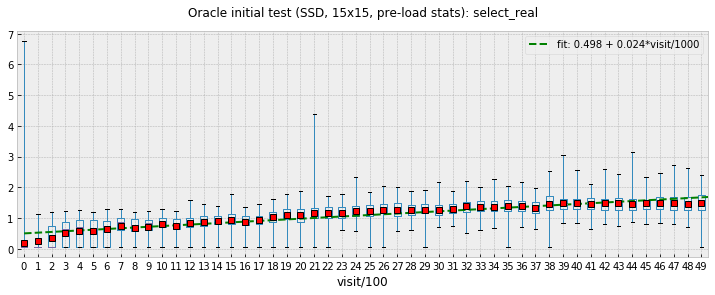

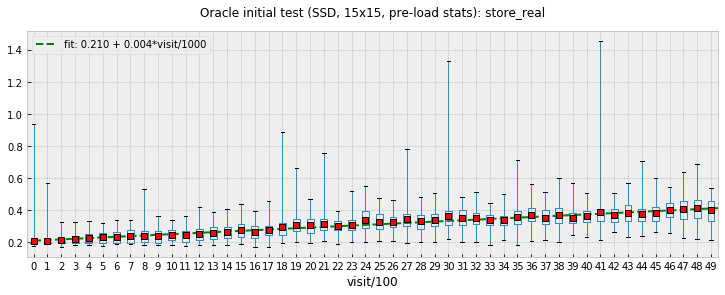

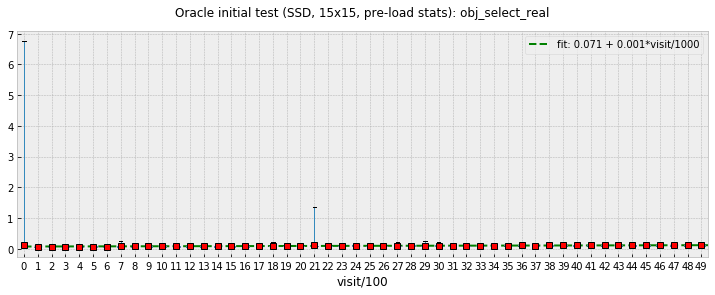

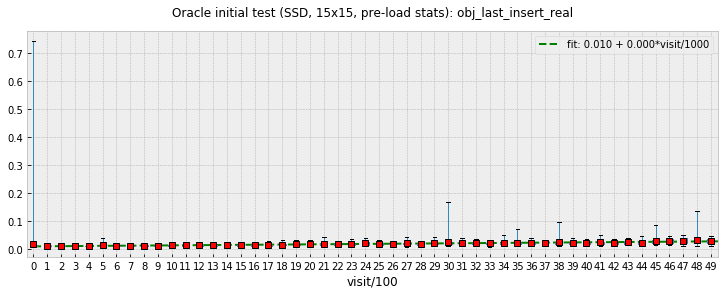

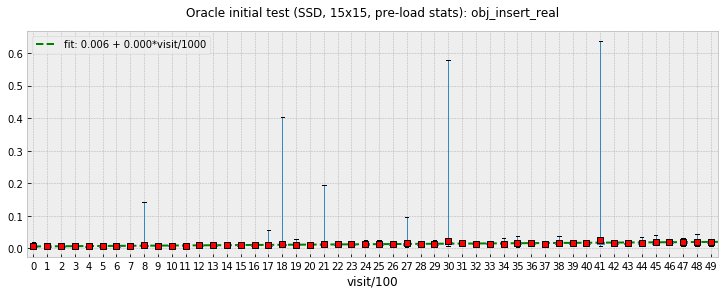

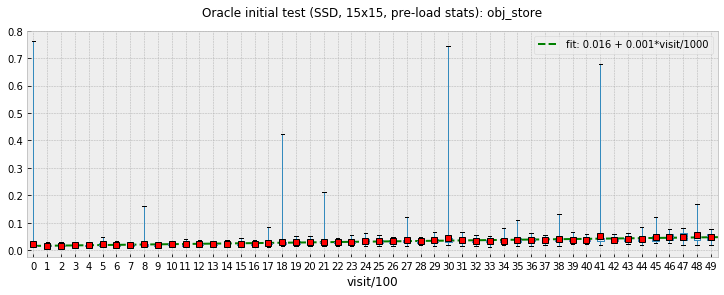

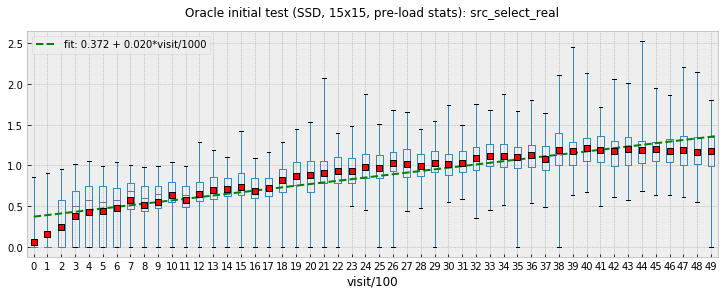

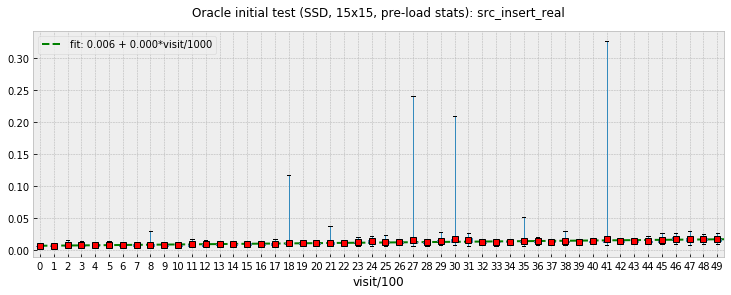

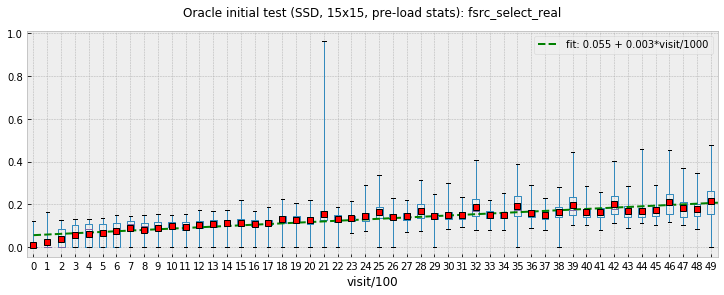

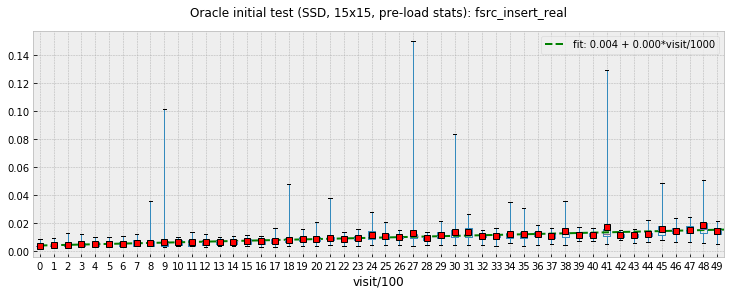

In [3]:
csv = "data/dm-14712-oracle-ssd-15x15-20180718T135354.csv.gz"
title = "Oracle initial test (SSD, 15x15, pre-load stats)"
ds = plots.do_plots(csv, title, bin=100, filter_count=True)
ds = plots.do_plots_all(ds, title, bin=100, filter_count=True, plots=all_plots)

## Re-tested without stats

* Re-run it again, re-creating tables but not re-loading stats
* Test was stopped due to maintenance at NCSA
* It is clearly worse than with pre-loaded stats and also looks worse than first test above

`dm-14712-oracle-ssd-15x15-20180718T235512.log.gz`:
```
2018-07-18 23:55:14,177 [INFO] lsst.l1dbproto.l1db: L1DB Configuration:
2018-07-18 23:55:14,178 [INFO] lsst.l1dbproto.l1db:     dia_object_index: last_object_table
2018-07-18 23:55:14,179 [INFO] lsst.l1dbproto.l1db:     dia_object_columns: ['diaObjectId', 'lastNonForcedSource', 'ra', 'decl', 'raSigma', 'declSigma', 'ra_decl_Cov', 'pixelId']
2018-07-18 23:55:14,179 [INFO] lsst.l1dbproto.l1db:     object_last_replace: True
2018-07-18 23:55:14,179 [INFO] lsst.l1dbproto.l1db:     schema_file: /project/salnikov/l1dbproto/data/l1db-schema.yaml
2018-07-18 23:55:14,180 [INFO] lsst.l1dbproto.l1db:     extra_schema_file: data/l1db-schema-extra-oracle.yaml
2018-07-18 23:55:14,180 [INFO] lsst.l1dbproto.l1db:     column_map: /project/salnikov/l1dbproto/data/l1db-afw-map.yaml
2018-07-18 23:55:14,180 [INFO] lsst.l1dbproto.l1db:     schema prefix: X15_
2018-07-18 23:55:14,810 [INFO] ap_proto: Will divide FOV into 15x15 regions
2018-07-18 23:55:16,272 [INFO] ap_proto: +++ Start processing visit 1 at 2020-01-01 03:00:00
...
2018-07-19 07:53:11,853 [INFO] ap_proto: --- Finished processing visit 617, time: real=89.309 user=1.220 sys=4.445
```

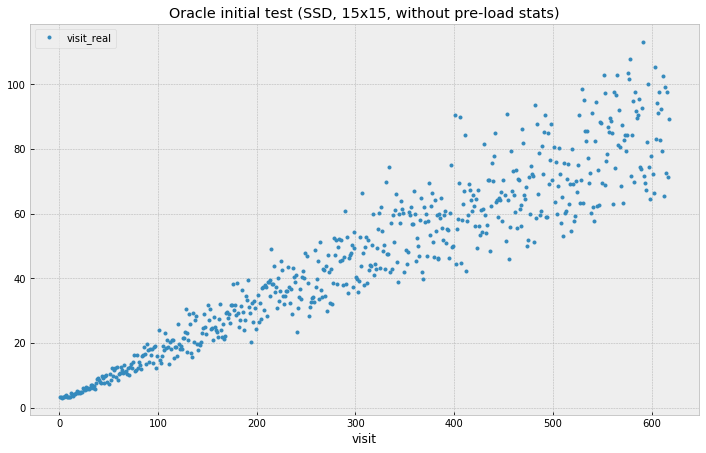

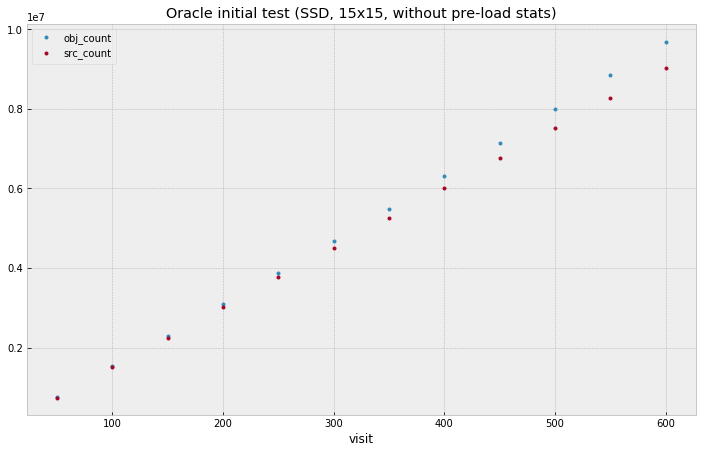

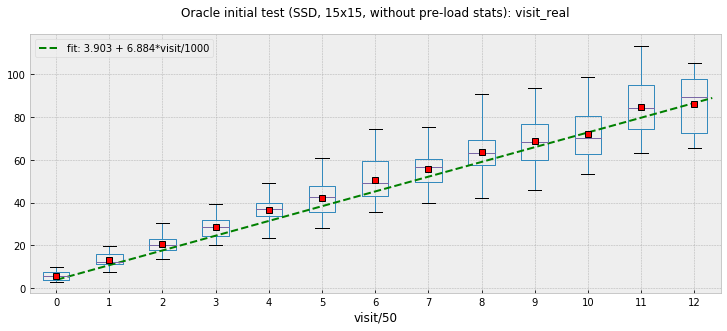

In [4]:
csv = "data/dm-14712-oracle-ssd-15x15-20180718T235512.csv.gz"
title = "Oracle initial test (SSD, 15x15, without pre-load stats)"
ds = plots.do_plots(csv, title, bin=50, filter_count=True)
# ds = plots.do_plots_all(csv, title, bin=100, filter_count=True, plots=all_plots)

## One more re-run without stats

* Shows similar degradation as the first step above, though behavior is slightly different

`dm-14712-oracle-ssd-15x15-20180720T005959.log.gz`:
```
2018-07-20 01:00:01,023 [INFO] lsst.l1dbproto.l1db: L1DB Configuration:
2018-07-20 01:00:01,024 [INFO] lsst.l1dbproto.l1db:     dia_object_index: last_object_table
2018-07-20 01:00:01,025 [INFO] lsst.l1dbproto.l1db:     dia_object_columns: ['diaObjectId', 'lastNonForcedSource', 'ra', 'decl', 'raSigma', 'declSigma', 'ra_decl_Cov', 'pixelId']
2018-07-20 01:00:01,025 [INFO] lsst.l1dbproto.l1db:     object_last_replace: True
2018-07-20 01:00:01,025 [INFO] lsst.l1dbproto.l1db:     schema_file: /project/salnikov/l1dbproto/data/l1db-schema.yaml
2018-07-20 01:00:01,025 [INFO] lsst.l1dbproto.l1db:     extra_schema_file: data/l1db-schema-extra-oracle.yaml
2018-07-20 01:00:01,025 [INFO] lsst.l1dbproto.l1db:     column_map: /project/salnikov/l1dbproto/data/l1db-afw-map.yaml
2018-07-20 01:00:01,025 [INFO] lsst.l1dbproto.l1db:     schema prefix: X15_
2018-07-20 01:00:01,572 [INFO] ap_proto: Will divide FOV into 15x15 regions
2018-07-20 01:00:01,828 [INFO] ap_proto: +++ Start processing visit 1 at 2020-01-01 03:00:00
...
2018-07-20 13:19:12,637 [INFO] ap_proto: --- Finished processing visit 3051, time: real=6.167 user=1.187 sys=4.962
```

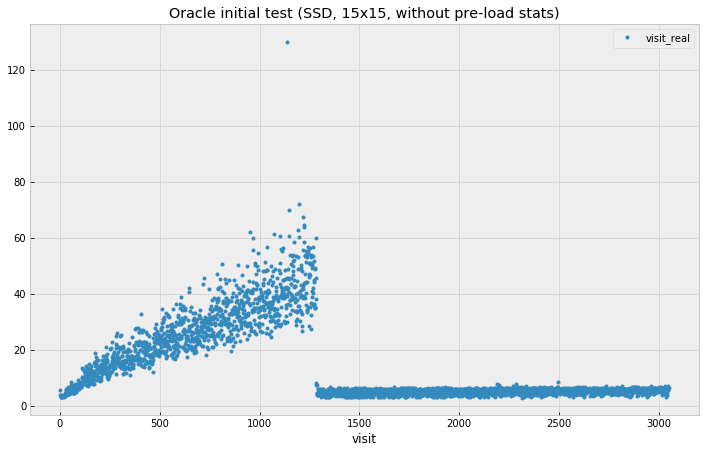

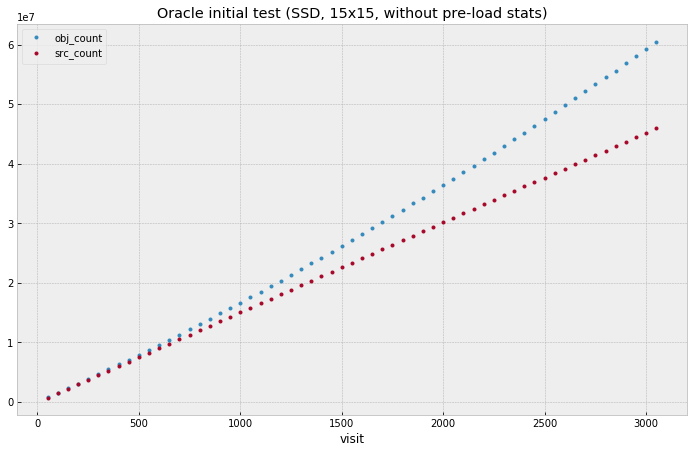

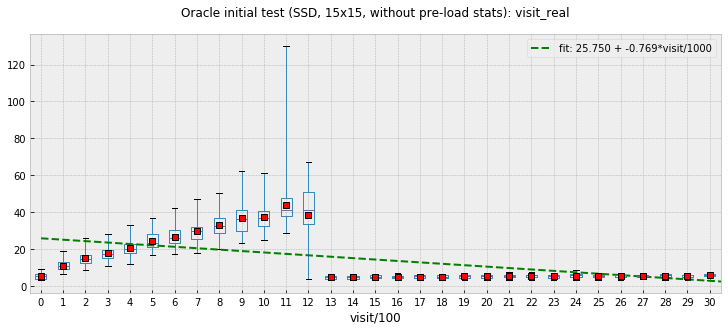

In [5]:
csv = "data/dm-14712-oracle-ssd-15x15-20180720T005959.csv.gz"
title = "Oracle initial test (SSD, 15x15, without pre-load stats)"
ds = plots.do_plots(csv, title, bin=100, filter_count=True)
# ds = plots.do_plots_all(csv, title, bin=100, filter_count=True, plots=all_plots)

## One more test without stats

* Looks like in this tests something prevets optimizer from locking into a better plan.

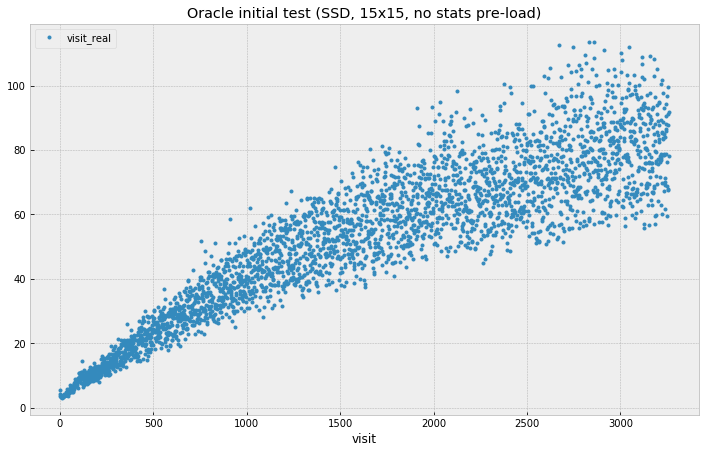

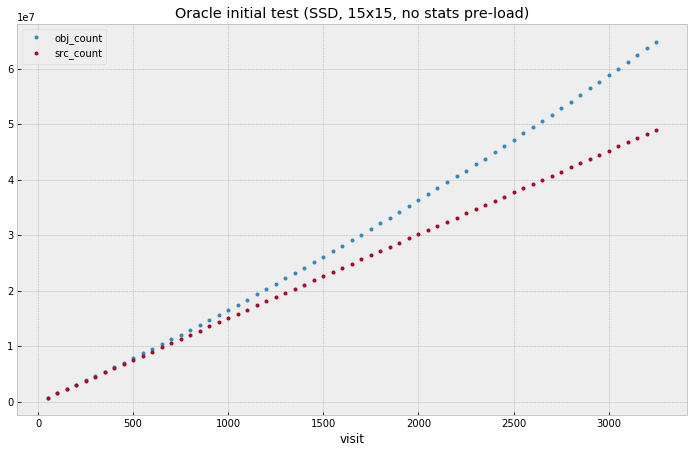

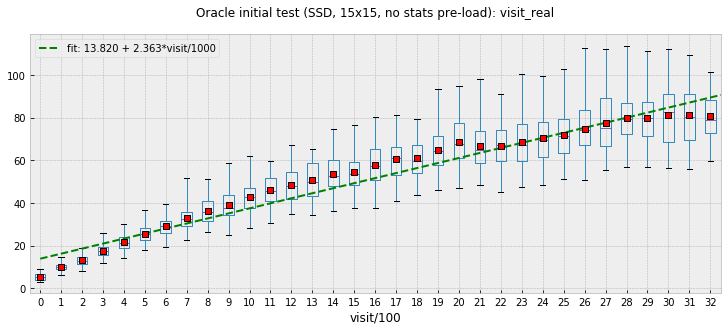

In [6]:
csv = "data/dm-14712-oracle-ssd-15x15-20180720T184634.csv.gz"
title = "Oracle initial test (SSD, 15x15, no stats pre-load)"
ds = plots.do_plots(csv, title, bin=100, filter_count=True)
# ds = plots.do_plots_all(csv, title, bin=100, filter_count=True, plots=all_plots)

## Repeat test with pre-loaded stats

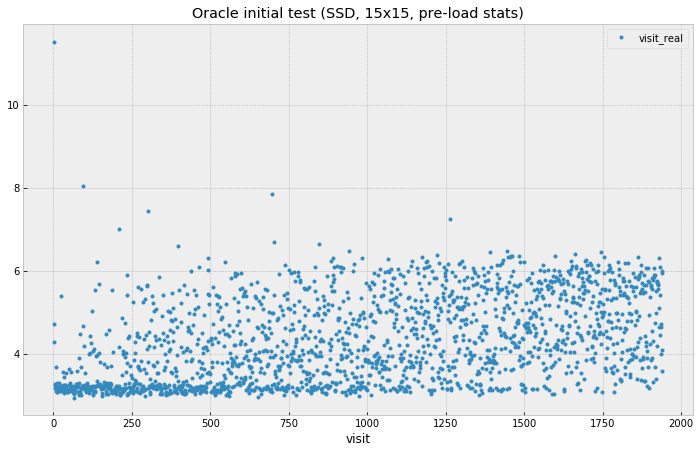

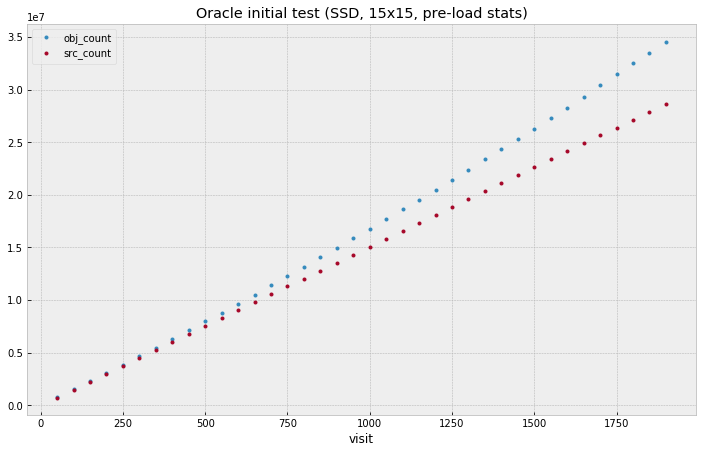

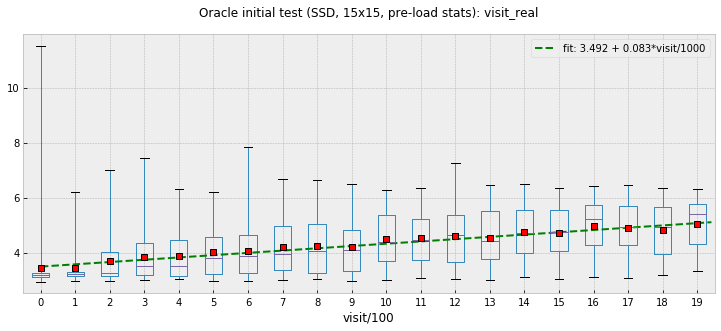

In [7]:
csv = "data/dm-14712-oracle-ssd-15x15-20180724T131111.csv.gz"
title = "Oracle initial test (SSD, 15x15, pre-load stats)"
ds = plots.do_plots(csv, title, bin=100, filter_count=True)
# ds = plots.do_plots_all(csv, title, bin=100, filter_count=True, plots=all_plots)

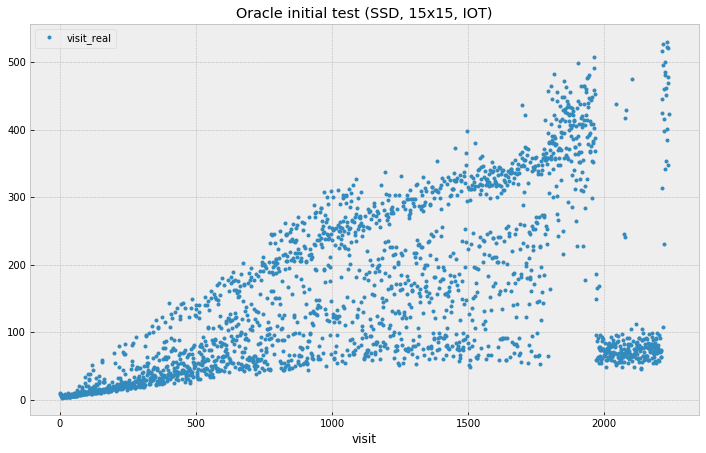

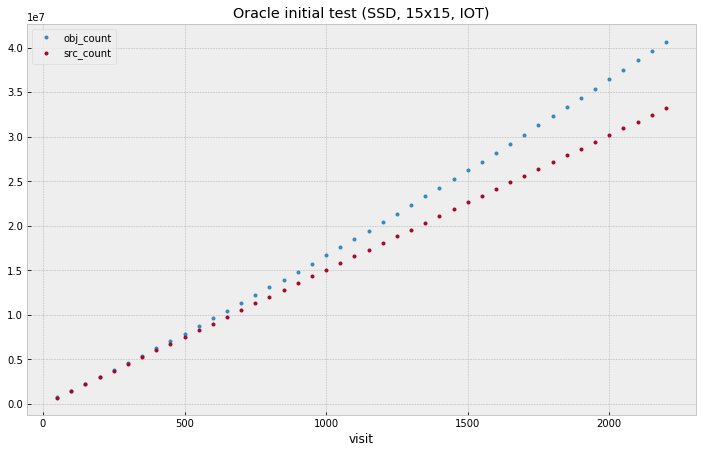

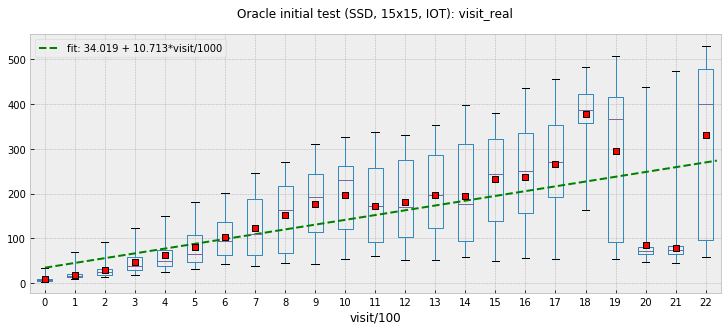

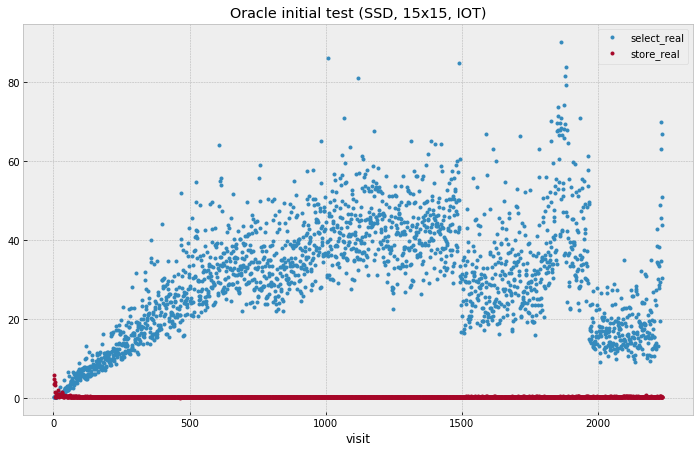

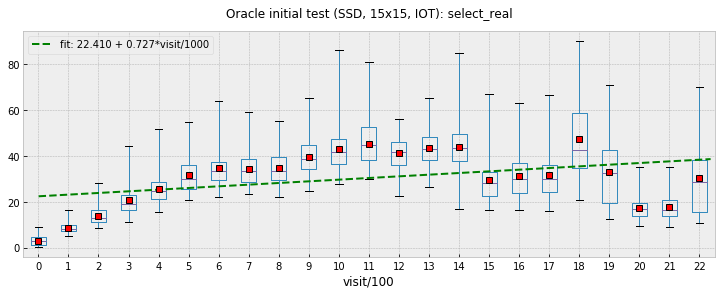

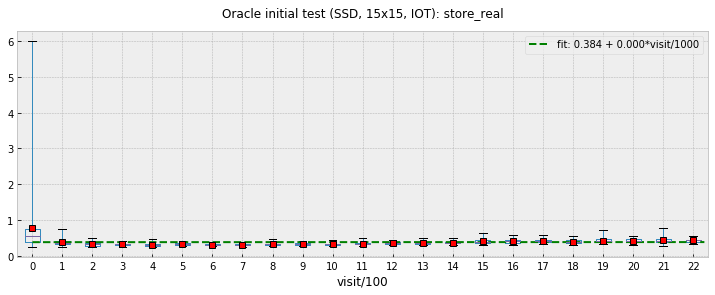

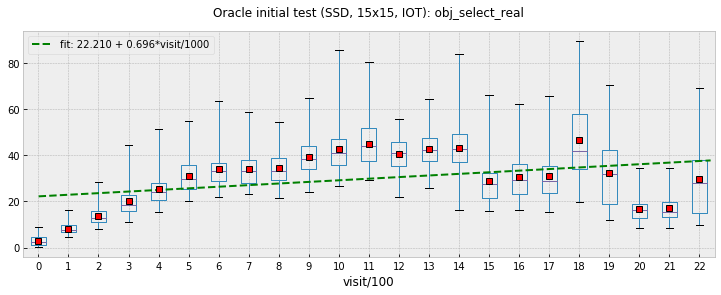

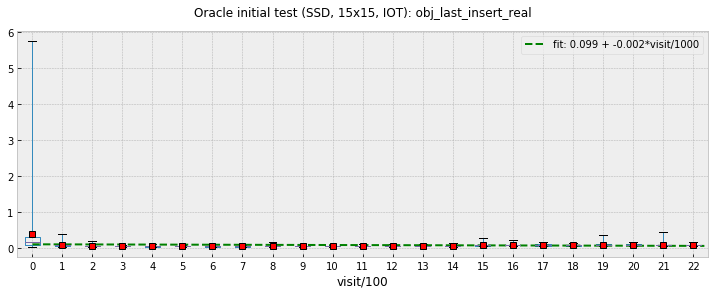

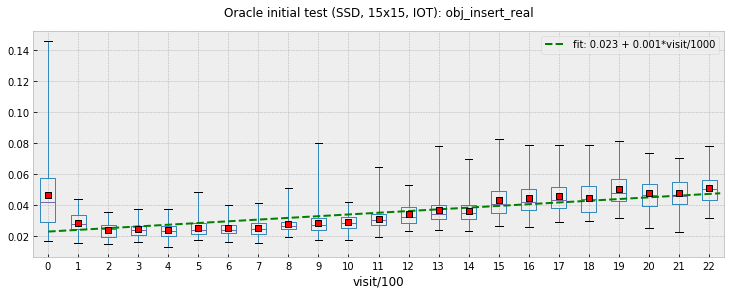

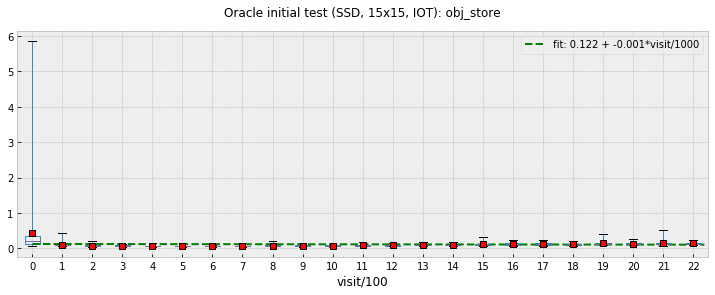

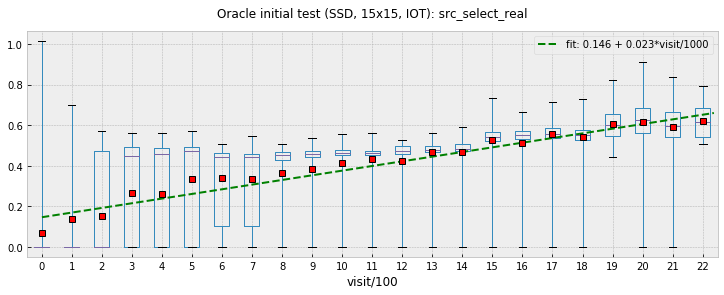

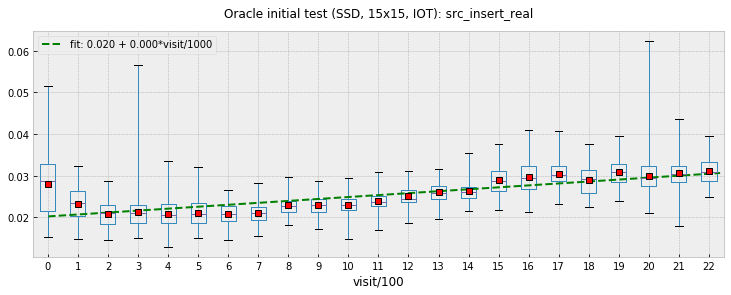

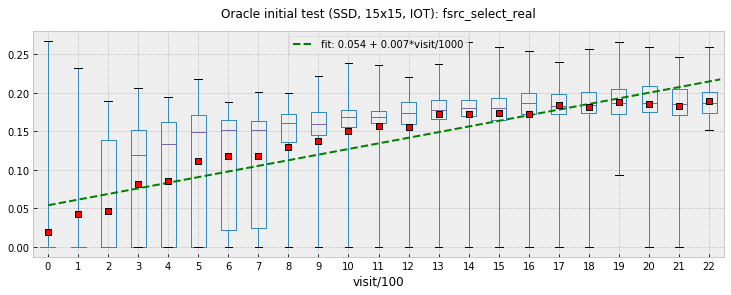

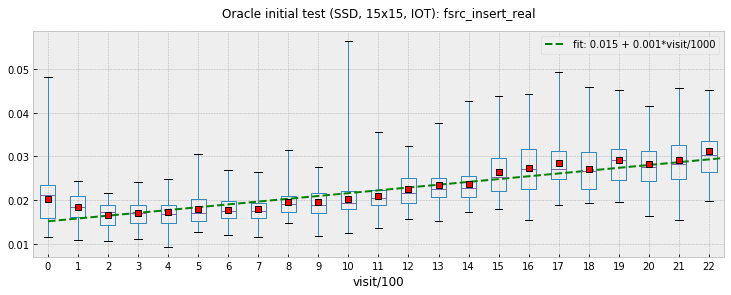

In [8]:
csv = "data/dm-14712-oracle-ssd-15x15-20180724T154618.csv.gz"
title = "Oracle initial test (SSD, 15x15, IOT)"
ds = plots.do_plots(csv, title, bin=100, filter_count=True)
ds = plots.do_plots_all(ds, title, bin=100, filter_count=True, plots=all_plots)

## Long test with narrow IOT

DiaObjectLast table was narrowed to contain only columns that are needed for matching. Using IOT for it too.

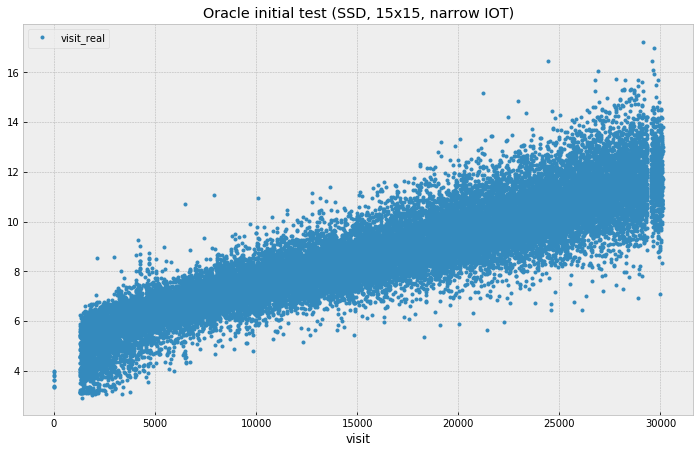

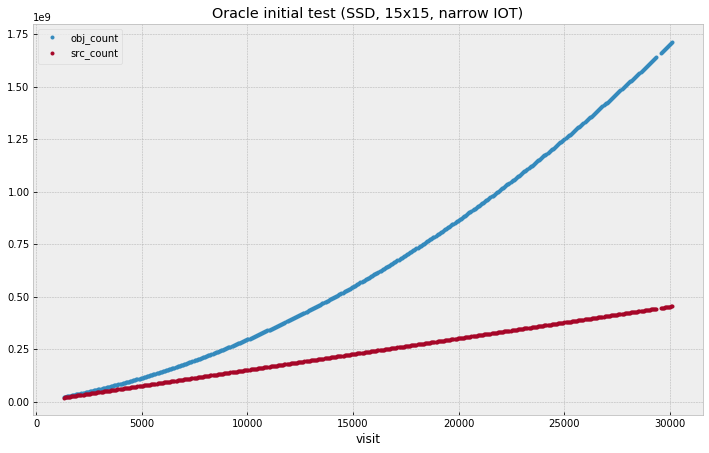

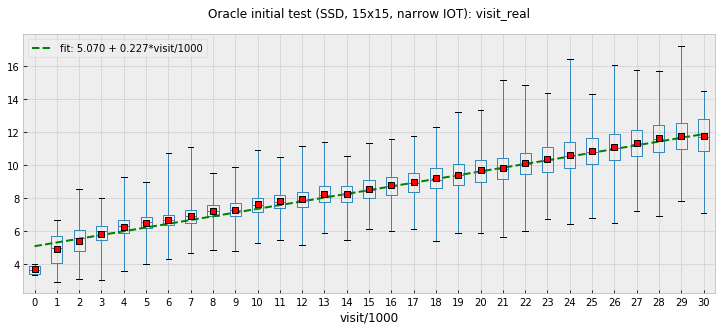

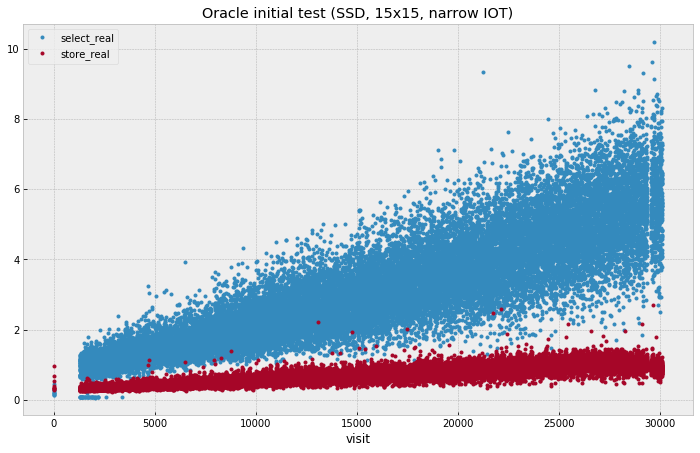

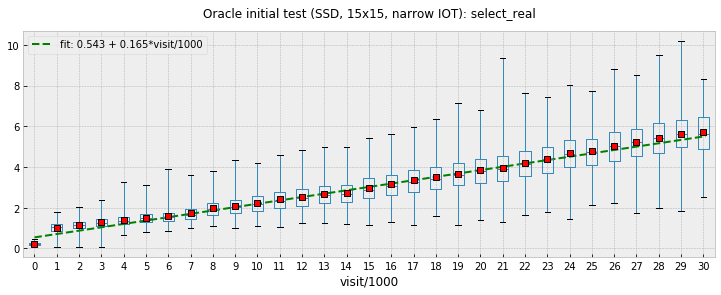

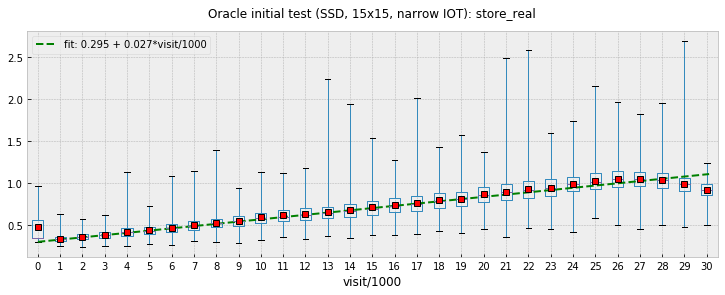

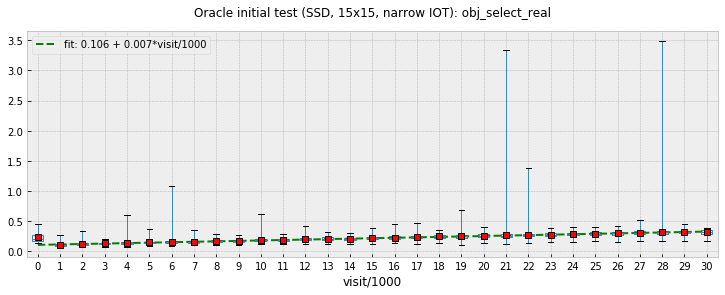

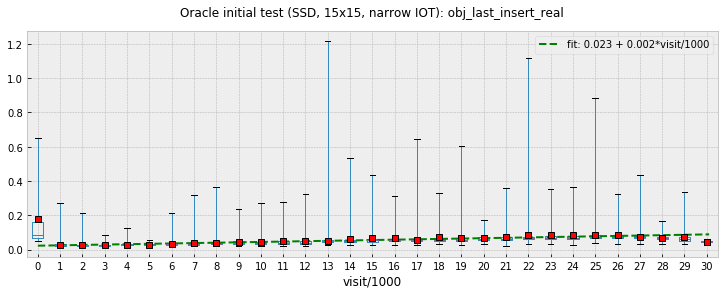

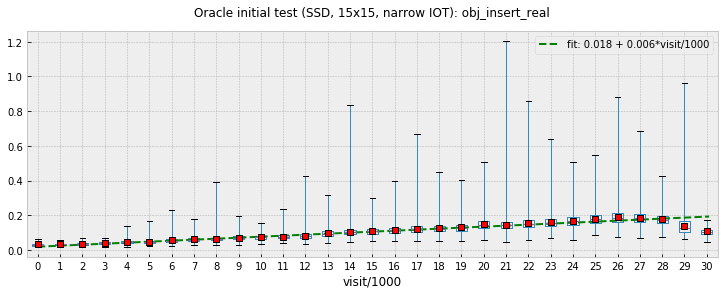

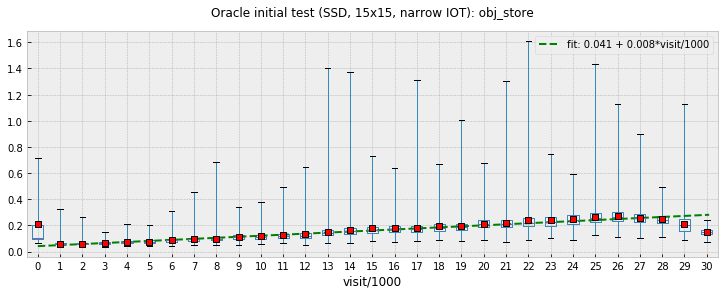

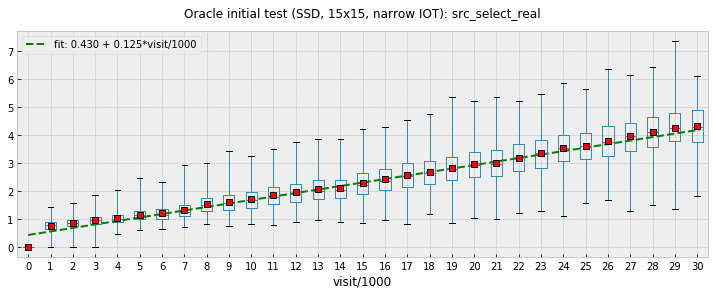

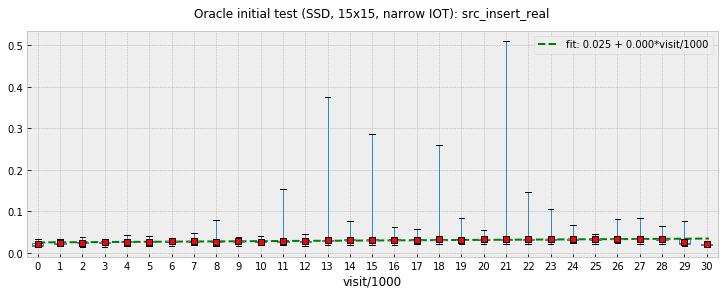

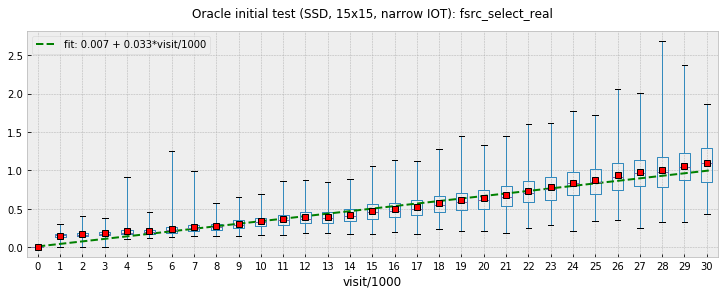

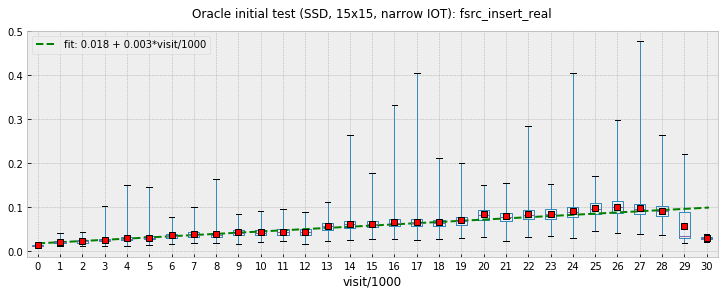

In [9]:
csv = "data/dm-14712-oracle-ssd-15x15-iot-narrow-20180731T232621.csv.gz"
title = "Oracle initial test (SSD, 15x15, narrow IOT)"
bad_visits = list(range(10, 1283)) + list(range(29352, 29517))
ds = plots.do_plots(csv, title, bin=1000, filter_count=True, bad_visits=bad_visits)
ds = plots.do_plots_all(ds, title, bin=1000, filter_count=True, plots=all_plots)